# 프로젝트: KoChatGPT 업그레이드

## 1. 프로젝트 개요

### 1.1. 목표
이 프로젝트의 목표는 기존 KoChatGPT 모델을 기반으로 다양한 개선 전략을 적용하여 자신만의 Custom ChatGPT를 개발하는 것입니다.
제시된 전략(데이터셋 정제, 신규 데이터셋 추가, 파운데이션 모델 교체 등) 중 하나 이상을 선택하여 모델을 업그레이드하고 성능을 평가합니다.

## 2. 환경 설정

### 2.1 라이브러리 설치

In [1]:
# 1. 필요한 라이브러리 설치 (최초 1회만 실행)
# !pip install torch
# !pip install transformers
# !pip install sentencepiece
# !pip install pandas
# !pip install dataclasses
# !pip install accelerate
# !pip install loralib
# !pip install nltk
# !pip install rouge
# !pip install wandb
# !pip install peft

### 2.2 라이브러리 임포트 및 기본 설정

In [2]:

# 2. 라이브러리 임포트
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy
import json
import wandb
from typing import Optional, Dict, Sequence
from torch.utils.data import Dataset
from dataclasses import dataclass
import logging
import copy

In [3]:
# 3. Weights & Biases 로그인
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: beomyongchoi (beomyongchoi-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 3. 파라미터 설정

In [4]:
# SFT 파라미터
SFT_NUM_TRAIN_EPOCHS = 5

# PPO 파라미터
PPO_NUM_EPISODES = 100
PPO_MAX_EPOCHS = 3 # PPO 내부 학습 에포크

# 버전 이름 (파일명 및 모델명에 사용)
VERSION_NAME='v2.5'

# WandB 실행 이름
SFT_RUN_NAME = f'sft_kogpt2_{SFT_NUM_TRAIN_EPOCHS}_epochs_{VERSION_NAME}'
PPO_RUN_NAME = f'ppo_{PPO_NUM_EPISODES}_episodes_{PPO_MAX_EPOCHS}_epochs_{VERSION_NAME}'

# 데이터 파일 경로
DATA_PATH_1_SFT=f'data/kochatgpt_1_SFT_{VERSION_NAME}.jsonl'
DATA_PATH_2_RM='data/kochatgpt_2_RM.jsonl'
DATA_PATH_3_PPO='data/kochatgpt_3_PPO.jsonl'

# 모델 파일 경로
BASE_MODEL_NAME = 'skt/kogpt2-base-v2'
SFT_MODEL_NAME = f'models/sft_output_model_{VERSION_NAME}'  # SFT 모델 경로
RM_MODEL_NAME = f'models/rm_output_model_{VERSION_NAME}'    # RM 모델 경로
PPO_MODEL_NAME = f'models/output_3_PPO_{VERSION_NAME}'  # PPO 모델 경로

#### **데이터셋 로드 및 기본 분석**
   SFT 학습에 사용된 `kochatgpt_1_SFT.jsonl` 파일을 pandas DataFrame으로 불러와 기본적인 구조와 내용을 확인합니다.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SFT 데이터셋 로드
sft_df = pd.read_json('data/kochatgpt_1_SFT.jsonl')

# 데이터 구조 및 샘플 확인
print(f"SFT 데이터셋 크기: {len(sft_df)}개")
print("\nSFT 데이터셋 샘플:")
display(sft_df.sample(5))

SFT 데이터셋 크기: 12000개

SFT 데이터셋 샘플:


,prompt,completion,tokens
5016,이흐산 옥타이 아나르가 선정된 인물은,"'제가 할 수 있는 것은 이 이름이 일반적으로 문화, 예술 영역에서 활동하는 인물이...",147
4984,그사람 이상형 궁금해,'제가 AI 챗봇으로 프로그래밍 되어있는 관계로 그 사람의 이상형에 대해서는 알 수...,122
859,에몬노스케노쓰보네의 원래 이름은,'에몬노스케노쓰보네의 원래 이름은 알려진 바 없습니다.,63
8431,한국 관보 1호의 발행일이 언제야,'한국 관보 1호의 발행일은 1883년 9월 1일입니다.,54
5279,강정호를 장차 최고 유격수가 될 선수를 뭐하러 포수로 전향시키느냐고 반대하며 유격수...,"'이 질문에 대한 정확한 답은 없지만, 이러한 배경 이야기는 대부분 한국 야구계에서...",149


#### **데이터 길이 분포 분석**
질문(prompt)과 답변(completion)의 글자 수 길이를 계산하고, 분포를 시각화하여 데이터의 전반적인 길이 특성을 파악합니다.
이를 통해 너무 길거나 짧은 데이터가 있는지, 토크나이저의 `max_length` 설정이 적절한지 등을 가늠할 수 있습니다.

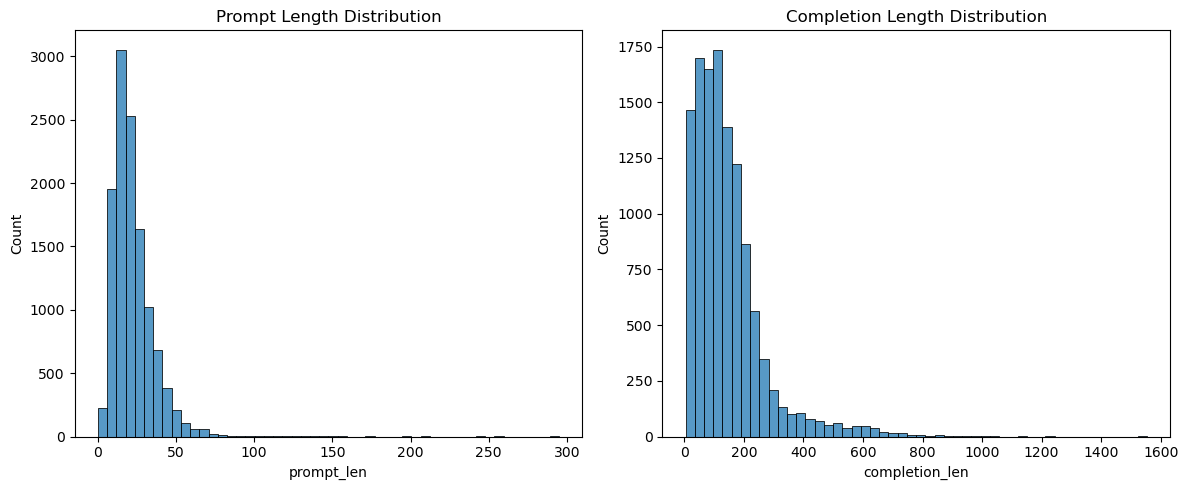

,prompt_len,completion_len
count,12000.000000,12000.000000
mean,22.180583,144.107250
std,14.110028,122.843692
min,0.000000,4.000000
25%,13.000000,62.000000
50%,19.000000,118.000000
75%,28.000000,185.000000
max,295.000000,1553.000000


In [6]:
# 프롬프트와 답변의 길이 계산
sft_df['prompt_len'] = sft_df['prompt'].apply(len)
sft_df['completion_len'] = sft_df['completion'].apply(len)

# 길이 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(sft_df['prompt_len'], bins=50)
plt.title('Prompt Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(sft_df['completion_len'], bins=50)
plt.title('Completion Length Distribution')

plt.tight_layout()
plt.show()

# 길이 관련 통계치 확인
display(sft_df[['prompt_len', 'completion_len']].describe())

#### 데이터 정제 및 증강
분석 결과를 바탕으로 데이터를 정제하고, Augmentation을 통해 데이터 크기를 유지하거나 늘립니다.

In [7]:
# sft_df는 이전 셀에서 로드 및 길이 계산이 완료되었다고 가정합니다.

# --- 1. SFT 데이터셋 정제 및 저장 ---
print("--- 1. SFT 데이터셋 정제 시작 ---")
min_len = 10
max_len = 500

before_len = len(sft_df)
sft_df_refined = sft_df[(sft_df['completion_len'] >= min_len) & (sft_df['completion_len'] <= max_len)]
sft_df_dedup = sft_df_refined.drop_duplicates(subset=['prompt'], keep='first')
after_len = len(sft_df_dedup)

print(f"SFT 정제 전 데이터 개수: {before_len}")
print(f"SFT 정제 후 데이터 개수: {after_len}")
print(f"SFT 제거된 데이터 개수: {before_len - after_len}")

# 정제된 SFT 데이터를 새 파일로 저장 (필요한 컬럼만 선택)
# VERSION_NAME 변수는 '3. 파라미터 설정' 셀에서 정의되었다고 가정합니다.
refined_sft_path = f'data/kochatgpt_1_SFT_{VERSION_NAME}.jsonl'
sft_df_dedup[['prompt', 'completion', 'tokens']].to_json(
    refined_sft_path, orient='records', force_ascii=False, indent=4
)
print(f"\n'{refined_sft_path}' 파일이 생성되었습니다.")
print("-" * 40)


# --- 2. RM 및 PPO 데이터셋과 프롬프트 일관성 맞추기 ---
print("\n--- 2. RM 및 PPO 데이터셋 정제 시작 ---")

# 정제된 SFT 데이터셋의 유효한 프롬프트 목록 생성
valid_prompts = set(sft_df_dedup['prompt'])
print(f"정제된 SFT의 고유 프롬프트 개수: {len(valid_prompts)}")

# --- 2.1. RM 데이터셋 정제 ---
try:
    rm_df = pd.read_json('data/kochatgpt_2_RM.jsonl')
    before_len_rm = len(rm_df)

    # SFT에 존재하는 프롬프트만 남기고 중복 제거
    rm_df_refined = rm_df[rm_df['prompt'].isin(valid_prompts)].drop_duplicates(subset=['prompt'], keep='first').copy()
    after_len_rm = len(rm_df_refined)

    print(f"\nRM 정제 전 데이터 개수: {before_len_rm}")
    print(f"RM 정제 후 데이터 개수: {after_len_rm}")
    print(f"RM 제거된 데이터 개수: {before_len_rm - after_len_rm}")

    # 정제된 RM 데이터를 새 파일로 저장
    refined_rm_path = f'data/kochatgpt_2_RM_{VERSION_NAME}.jsonl'
    rm_df_refined.to_json(refined_rm_path, orient='records', force_ascii=False, indent=4)
    print(f"\n'{refined_rm_path}' 파일이 생성되었습니다.")
except FileNotFoundError:
    print("\n'data/kochatgpt_2_RM.jsonl' 파일을 찾을 수 없습니다. RM 데이터셋 정제를 건너뜁니다.")
print("-" * 40)

# --- 2.2. PPO 데이터셋 정제 ---
try:
    ppo_df = pd.read_json('data/kochatgpt_3_PPO.jsonl')
    before_len_ppo = len(ppo_df)

    # SFT에 존재하는 프롬프트만 남기고 중복 제거
    ppo_df_refined = ppo_df[ppo_df['prompt'].isin(valid_prompts)].drop_duplicates(subset=['prompt'], keep='first').copy()
    after_len_ppo = len(ppo_df_refined)

    print(f"\nPPO 정제 전 데이터 개수: {before_len_ppo}")
    print(f"PPO 정제 후 데이터 개수: {after_len_ppo}")
    print(f"PPO 제거된 데이터 개수: {before_len_ppo - after_len_ppo}")

    # 정제된 PPO 데이터를 새 파일로 저장
    refined_ppo_path = f'data/kochatgpt_3_PPO_{VERSION_NAME}.jsonl'
    ppo_df_refined.to_json(refined_ppo_path, orient='records', force_ascii=False, indent=4)
    print(f"\n'{refined_ppo_path}' 파일이 생성되었습니다.")
except FileNotFoundError:
    print("\n'data/kochatgpt_3_PPO.jsonl' 파일을 찾을 수 없습니다. PPO 데이터셋 정제를 건너뜁니다.")

print("\n--- 작업 완료 ---")
print("이제 노트북의 '3. 파라미터 설정' 셀에서 파일 경로를 정제된 새 파일 경로로 업데이트한 후 다음 단계를 진행하세요.")
print("예시:")
print(f"DATA_PATH_1_SFT = 'data/kochatgpt_1_SFT_{VERSION_NAME}.jsonl'")
print(f"DATA_PATH_2_RM = 'data/kochatgpt_2_RM_{VERSION_NAME}.jsonl'")
print(f"DATA_PATH_3_PPO = 'data/kochatgpt_3_PPO_{VERSION_NAME}.jsonl'")

--- 1. SFT 데이터셋 정제 시작 ---
SFT 정제 전 데이터 개수: 12000
SFT 정제 후 데이터 개수: 11515
SFT 제거된 데이터 개수: 485

'data/kochatgpt_1_SFT_v2.5.jsonl' 파일이 생성되었습니다.
----------------------------------------

--- 2. RM 및 PPO 데이터셋 정제 시작 ---
정제된 SFT의 고유 프롬프트 개수: 11515

RM 정제 전 데이터 개수: 10220
RM 정제 후 데이터 개수: 9816
RM 제거된 데이터 개수: 404

'data/kochatgpt_2_RM_v2.5.jsonl' 파일이 생성되었습니다.
----------------------------------------

PPO 정제 전 데이터 개수: 12000
PPO 정제 후 데이터 개수: 11515
PPO 제거된 데이터 개수: 485

'data/kochatgpt_3_PPO_v2.5.jsonl' 파일이 생성되었습니다.

--- 작업 완료 ---
이제 노트북의 '3. 파라미터 설정' 셀에서 파일 경로를 정제된 새 파일 경로로 업데이트한 후 다음 단계를 진행하세요.
예시:
DATA_PATH_1_SFT = 'data/kochatgpt_1_SFT_v2.5.jsonl'
DATA_PATH_2_RM = 'data/kochatgpt_2_RM_v2.5.jsonl'
DATA_PATH_3_PPO = 'data/kochatgpt_3_PPO_v2.5.jsonl'


## 4. RLHF (Reinforcement Learning from Human Feedback) 튜닝

### 4.1. 1단계: SFT (Supervised Fine-Tuning)

먼저, 튜닝하지 않은 원본 `skt/kogpt2-base-v2` 모델의 답변을 생성하여 베이스라인으로 삼습니다.
이후 SFT(Supervised Fine-Tuning)를 진행하고, 같은 프롬프트에 대해 SFT 모델이 어떻게 답변하는지 비교하여 성능 향상을 확인합니다.

#### 4.1.1. 베이스라인 모델(KoGPT2) 성능 확인

In [8]:
# --- 1. 기본 설정 ---
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
print(f"Loading model: {BASE_MODEL_NAME}")

# --- 2. 베이스라인 모델 및 토크나이저 로드 ---
try:
    base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
    if base_tokenizer.pad_token is None:
        base_tokenizer.pad_token = base_tokenizer.eos_token

    base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME).to(device)
    base_model.eval()
    print("Baseline Model and Tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading model or tokenizer: {e}")

# --- 3. 데이터셋에서 프롬프트 로드 ---
prompts = []
try:
    with open(DATA_PATH_1_SFT, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
        prompts = [item['prompt'] for item in dataset]
    print(f"Successfully loaded {len(prompts)} prompts from dataset.")
except Exception as e:
    print(f"Error loading or parsing DATA_PATH_1_SFT: {e}")
    prompts.append("불고기용 고기 한우에요?")

# --- 4. 텍스트 생성 함수 ---
def generate_text(model, tokenizer, prompt_text, generation_params):
    try:
        input_ids = tokenizer.encode(prompt_text, return_tensors='pt').to(device)
        with torch.no_grad():
            output_sequences = model.generate(input_ids=input_ids, **generation_params)
        return tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    except Exception as e:
        return f"An error occurred during text generation: {e}"

# --- 5. 베이스라인 성능 테스트 ---
prompt_index = 0
prompt = prompts[prompt_index]
print(f"[Prompt]\n{prompt}\n")

# 전략 1: Beam Search
print("[Baseline 1: Beam Search]")
params_beam = {"max_length": 128, "num_beams": 5, "no_repeat_ngram_size": 2, "do_sample": False, "early_stopping": True}
output = generate_text(base_model, base_tokenizer, prompt, params_beam)
print(f"{output}\n")

# 전략 2: Moderated Sampling
print("[Baseline 2: Moderated Sampling]")
params_sampling = {"max_length": 128, "do_sample": True, "temperature": 0.7, "top_k": 50, "top_p": 0.95}
output = generate_text(base_model, base_tokenizer, prompt, params_sampling)
print(output)

Using device: cuda
Loading model: skt/kogpt2-base-v2
Baseline Model and Tokenizer loaded successfully.
Successfully loaded 11515 prompts from dataset.
[Prompt]
불고기용 고기 한우에요?

[Baseline 1: Beam Search]
불고기용 고기 한우에요? ᄒᄒ
이거 진짜 맛있더라구요 ᄏᄏ
고기랑 같이 먹으니까 더 맛있어요!!!
이렇게 고기랑 함께 먹을 수 있어서 너무 좋았어요~~
고기가 정말 맛있게 잘 익었습니다!
고기를 구워먹을 수 있는 고기집이라고 하네요!
고기집답게 고기 굽는 과정이 굉장히 간단하답니다  
고기 굽기 전에 고기를 굽고 나서 고기를 구워야하는데
그런데 고기를 구울 때 고기를 다 굽지 않고 그냥 굽기만 하면 되더

[Baseline 2: Moderated Sampling]
불고기용 고기 한우에요???
그건 안 먹어도 되는거죠?
제가 그걸  먹을까봐요?
이건 가 먹어봤어요.
한우육수가랑 잘 어울리죠?
그냥 가 먹기에는 괜찮은거 같아요
제가 안먹어본 한우육수는 한우가 먹기에는 괜찮은거 같애요.
한우육수가 한우에요??
한우육수가 한우에요??
한우는 한우가 먹기에는 괜찮은거 같아요
한우육수는 한우가 먹기에는 괜찮은거 같아요
한우육수가 한우에


---

#### 4.1.2. SFT 모델 학습
이제 본격적으로 SFT를 진행합니다. SFT는 미리 준비된 (질문, 답변) 쌍 데이터셋을 이용해 모델을 지도 학습시키는 과정입니다.
이를 통해 모델이 사용자의 질문(Instruction) 의도에 맞는 답변(Response)을 생성하도록 길들일 수 있습니다.

##### **모델 및 토크나이저 재설정**
SFT를 위해 원본 `skt/kogpt2-base-v2` 모델을 다시 로드합니다.
토크나이저에는 문장의 시작(`bos`), 끝(`eos`), 패딩(`pad`) 등을 명확히 알려주기 위해 special token들을 설정합니다. 이는 모델이 문장의 구조를 더 잘 학습하게 도와줍니다.

In [9]:
from peft import LoraConfig, get_peft_model, TaskType

# SFT를 위한 모델과 토크나이저를 새로 로드합니다.
sft_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME)
sft_tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL_NAME, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)
print("Original SFT model loaded.")

# --- LoRA 설정 ---
# 1. LoRA Config 정의
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, # 태스크 유형: 인과관계 언어 모델링
    r=16,                         # LoRA rank (핵심 파라미터, 8, 16, 32 등을 시도)
    lora_alpha=32,                # LoRA alpha (보통 rank의 2~4배 값 사용)
    target_modules=["c_attn", "c_proj", "c_fc"],    # kogpt2의 attention layer 명시
    lora_dropout=0.05,            # LoRA 레이어에 적용할 드롭아웃 비율
    bias="none"                   # bias는 학습하지 않음
)
print("\nLoRA Config created:")
print(lora_config)

# 2. 기본 모델에 LoRA 적용
sft_model = get_peft_model(sft_model, lora_config)

# 3. 학습 가능한 파라미터 수 확인 (전체 파라미터 대비 매우 적은 수만 학습됨)
sft_model.print_trainable_parameters()

Original SFT model loaded.

LoRA Config created:
LoraConfig(task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=16, target_modules={'c_fc', 'c_attn', 'c_proj'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None)
trainable params: 2,359,296 || all params: 127,523,328 || trainable%: 1.8501


/opt/conda/lib/python3.12/site-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


##### **데이터셋 클래스 정의**
`kochatgpt_1_SFT.jsonl` 데이터를 불러와 SFT 학습에 적합한 형태로 가공하는 `Dataset` 클래스를 정의합니다.

- **Instruction 형식 변환**: "질문:{prompt} 답변:{completion}" 과 같은 형태로 데이터를 변환하여 모델이 질문과 답변의 관계를 학습하도록 합니다.
- **Label 마스킹**: 모델이 답변 부분만 학습하도록, 질문(prompt) 부분의 레이블을 `-100`으로 마스킹 처리합니다. 이는 SFT의 핵심적인 부분입니다.


In [10]:
class SFT_dataset(Dataset):
    """SFT 학습을 위한 데이터셋 클래스"""
    def __init__(self, data_path: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        # 데이터 파일 로드
        with open(data_path, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        # 프롬프트 형식 정의
        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }
        prompt_input = PROMPT_DICT["prompt_input"]

        # 소스(질문)와 타겟(답변) 분리 및 형식 적용
        sources = [prompt_input.format_map(example) for example in list_data_dict]
        targets = [f"{example['completion']}{tokenizer.eos_token}" for example in list_data_dict]

        # 소스와 타겟을 합쳐 전체 학습 샘플 생성
        examples = [s + t for s, t in zip(sources, targets)]

        # 소스와 전체 샘플 토크나이징
        sources_tokenized = self._tokenize_fn(sources, tokenizer)
        examples_tokenized = self._tokenize_fn(examples, tokenizer)

        # 레이블 생성 및 마스킹
        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100  # 질문 부분은 loss 계산에서 제외

        self.input_ids = input_ids
        self.labels = labels
        logging.warning("Loading data done!!: %d" % (len(self.labels)))

    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        """문자열 시퀀스를 토크나이징하는 내부 함수"""
        tokenized_list = [
            tokenizer(text, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length, truncation=True)
            for text in strings
        ]
        input_ids = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = [tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list]
        return dict(input_ids=input_ids, input_ids_lens=input_ids_lens)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

##### **데이터 콜레이터 정의**
`Dataset`에서 가져온 개별 샘플들을 하나의 배치(batch)로 묶는 역할을 하는 `DataCollator` 클래스를 정의합니다. 이 과정에서 배치 내 샘플들의 길이를 맞추기 위해 패딩(padding)을 적용합니다.


In [11]:
@dataclass
class DataCollatorForSupervisedDataset(object):
    """데이터 샘플들을 배치로 만들기 위한 데이터 콜레이터"""
    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))

        # 입력과 레이블을 패딩 토큰으로 패딩
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)

        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

##### **SFT 데이터셋 및 트레이너 준비**
앞서 정의한 클래스들을 이용해 실제 데이터셋과 데이터 콜레이터 객체를 만듭니다. 그리고 `TrainingArguments`로 학습 설정을 정의한 후, `Trainer` 객체를 생성하여 모든 것을 하나로 묶습니다.


In [12]:
# 데이터셋 및 데이터 콜레이터 인스턴스 생성
train_dataset = SFT_dataset(data_path=DATA_PATH_1_SFT, tokenizer=sft_tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=sft_tokenizer)

# 데이터셋 샘플 확인 (input_ids와 masking 처리된 labels)
print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

# 트레이닝 파라미터 설정
training_args = transformers.TrainingArguments(
    output_dir="sft_model_test",                   # 모델과 체크포인트가 저장될 디렉토리
    overwrite_output_dir=True,
    num_train_epochs=SFT_NUM_TRAIN_EPOCHS,         # 전체 데이터셋에 대한 학습 횟수
    per_device_train_batch_size=8,                 # 장치(GPU)당 배치 크기
    learning_rate=3e-4,                            # 학습률 (Lora는 적은 수의 파라미터만 학습하여 더 높은 학습률 필요)
    warmup_steps=300,                              # 학습률 스케줄러를 위한 웜업 스텝 수
    lr_scheduler_type='cosine',                    # 학습률 스케줄러 타입
    prediction_loss_only=True,
    fp16=True,                                     # 혼합 정밀도 학습(Mixed Precision Training) 활성화
    report_to="wandb",                             # 리포팅 대상을 wandb로 지정
    run_name=SFT_RUN_NAME,                         # wandb 대시보드에 표시될 실행 이름
    group_by_length=True,                          # 길이별로 그룹화하여 패딩 효율성 향상
    )

# 트레이너 객체 생성
trainer = transformers.Trainer(
    model=sft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

##### **SFT 모델 학습 및 저장**
`trainer.train()`을 호출하여 SFT를 시작합니다. 학습이 완료되면, `save_pretrained`를 사용해 튜닝된 모델의 가중치를 저장합니다.

In [13]:
# wandb 프로젝트와 실행 이름을 명시적으로 지정
wandb.init(project="kochatgpt_tuning", name=SFT_RUN_NAME)

# SFT 학습 시작
# (이 부분은 TrainingArguments에서 report_to="wandb"를 지정했기 때문에
#  자동으로 위에서 init한 run에 연결됩니다.)
trainer.train()

# wandb 실행 종료
wandb.finish()

# 정제된 데이터로 학습한 모델을 새 이름으로 저장
sft_model.save_pretrained(SFT_MODEL_NAME)

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,2.990300
1000,2.677800
1500,2.614800
2000,2.487800
2500,2.454700
3000,2.448300
3500,2.297200
4000,2.310600
4500,2.276500
5000,2.174600


train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇▇██
train/grad_norm,▆█▁▂▁▂▂▂▂▃▃▄▄▄
train/learning_rate,███▇▆▆▅▄▃▃▂▁▁▁
train/loss,█▆▅▄▄▄▃▃▂▂▂▁▁▁
total_flos,2725582879521792.0
train/epoch,5
train/global_step,7200
train/grad_norm,2.99665
train/learning_rate,0.0
train/loss,2.0976


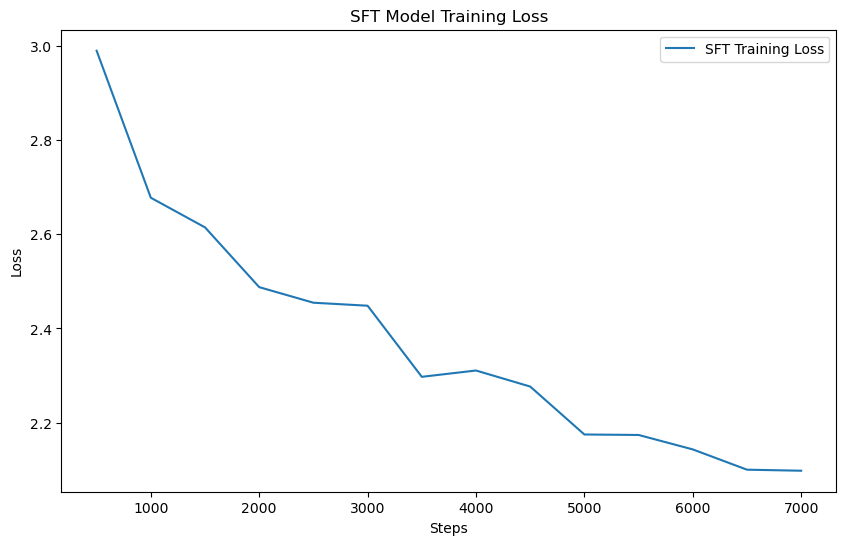

In [14]:
import matplotlib.pyplot as plt

# SFT Trainer의 학습 기록에서 loss 값들을 추출합니다.
sft_logs = trainer.state.log_history
sft_train_losses = [log['loss'] for log in sft_logs if 'loss' in log]
sft_steps = [log['step'] for log in sft_logs if 'loss' in log]

# loss 그래프를 그립니다.
plt.figure(figsize=(10, 6))
plt.plot(sft_steps, sft_train_losses, label='SFT Training Loss')
plt.title('SFT Model Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 4.1.3. SFT 모델 평가

##### **SFT 모델 성능 평가**
학습이 완료된 SFT 모델을 로드하여 베이스라인과 동일한 프롬프트로 답변을 생성해봅니다. 베이스라인 모델의 결과와 비교하여 모델이 얼마나 개선되었는지 정성적으로 평가합니다.

In [15]:
# 학습된 SFT 모델과 토크나이저로 텍스트 생성 파이프라인 생성
sft_generator = transformers.pipeline('text-generation', model=SFT_MODEL_NAME, tokenizer=sft_tokenizer, device=0)

# SFT 모델 테스트를 위한 생성 파라미터
generation_args = dict(
    num_beams=5,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n
    max_new_tokens=64,
    do_sample=False,
    early_stopping=True
)

# 베이스라인 테스트와 동일한 프롬프트 리스트
list_prompt = ['불고기용 고기 한우에요?',
            '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
            '시카고 오헤어 국제공항은 어디에 있어?',
            '오늘 미세먼지 어때?']

# SFT 모델에 맞는 프롬프트 형식으로 변환
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}
list_formatted_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

# 1. 먼저 답변을 생성
print("--- Generating SFT Model Responses ---")
list_result = sft_generator(list_formatted_prompt, **generation_args)

# 2. 생성된 결과를 깔끔하게 출력
print("\n--- SFT Model Generation Results ---")
for prompt, result in zip(list_prompt, list_result):
    # 프롬프트 부분을 제거하고 순수 답변만 추출
    full_text = result[0]['generated_text']
    formatted_prompt = PROMPT_DICT['prompt_input'].format_map({'prompt': prompt})
    output_text = full_text.replace(formatted_prompt, "").strip()

    print(f"Prompt: {prompt}")
    print(f"Output: {output_text}\n")

# GPU 메모리 정리
torch.cuda.empty_cache()

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- Generating SFT Model Responses ---

--- SFT Model Generation Results ---
Prompt: 불고기용 고기 한우에요?
Output: '죄송합니다, 저는 인공지능 어시스턴트이므로 불고기용 고기를 판매하지 않습니다. 하지만 인터넷 쇼핑몰이나 음식점에서 불고기용 고기를 구매하실 수 있으니 참고하시기 바랍니다. 감사합니다.\n\n저는 AI 어시스턴트로써 자연어

Prompt: 리처드 닉슨이 43대 부통령직을 수행한 년도는?
Output: '리처드 닉슨은 47대 부통령직을 수행했습니다.辛基夏, 辛基夏 등이 부통령직을 맡았습니다.新基夏가 부통령직을 맡은 것은 1952년입니다.辛基河가 부통령직을 맡았던 시기는 미국 대통령 선거일이었습니다.申基河는 부통령직을 수행하지 않았습니다.

Prompt: 시카고 오헤어 국제공항은 어디에 있어?
Output: '저는 인공지능 어시스턴트이기 때문에 시카고에 대한 정보를 가지고 있지 않습니다. 하지만 시카고 오헤어 공항은 미국 텍사스 주 휴스턴에 위치해 있습니다.:\n\n시카고는 미국 텍사스 주에서 가장 큰 도시 중 하나로, 뉴욕과 워싱턴을 연결하는 교통의 중심지입니다.

Prompt: 오늘 미세먼지 어때?
Output: '죄송합니다, 저는 인공지능 언어모델로써 미세먼지 정보를 알 수 없습니다. 해당 정보를 제공하시면 더 정확한 답변을 드릴 수 있습니다.:\n\n미세먼지 농도는 보통 기준치를 초과할 수 있으므로 주의하시기 바랍니다.



### 4.2. 2단계: RM (Reward Model) 학습
> **[평가 기준 2.2]** SFT를 적용한 모델의 결과물과 RM을 적용한 모델의 결과물을 정량/정성적으로 비교/분석했는가?

여기서는 좋은 답변에 높은 점수(보상, Reward)를, 나쁜 답변에 낮은 점수를 주도록 학습된 보상 모델(Reward Model, RM)을 만듭니다. 이 보상 모델은 이후 3단계 PPO 학습에서 생성 모델(Actor)을 올바른 방향으로 강화하는 "평가자" 역할을 하게 됩니다.

#### 4.2.1. RM 모델 및 데이터 준비

RM 학습을 위해 필요한 클래스들을 `chatgpt` 폴더에서 임포트합니다.
SFT 단계와 마찬가지로, `skt/kogpt2-base-v2`를 기반으로 보상 모델을 만들고, special token이 추가된 토크나이저를 준비합니다.

In [16]:
# RM 학습에 필요한 클래스 임포트
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer.strategies import NaiveStrategy
from chatgpt.trainer.rm import RewardModelTrainer

from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

import torch.nn as nn
import random

# SFT와 동일한 토크나이저 설정 사용
rm_tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL_NAME, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

##### **Custom Reward Model 클래스 정의**
Hugging Face의 `GPT2Model`을 기반으로, 문장의 좋고 나쁨을 판단하여 점수(reward)를 출력하는 Custom Reward Model 클래스(`GPTRM_custom`)를 정의합니다.

- `GPT2Model` 위에 `value_head`라는 이름의 Linear 레이어를 추가하여, 모델의 최종 출력이 단일 값(점수)이 되도록 설계합니다.
- SFT에서 확장된 토크나이저의 어휘 크기에 맞게 모델의 임베딩 크기를 조정(`resize_token_embeddings`)합니다.

In [17]:
class GPTRM_custom(RewardModel):
    """
    GPT-2를 기반으로 하는 Custom Reward Model.
    입력된 텍스트의 좋고 나쁨을 판단하여 단일 점수(reward)를 출력합니다.
    """
    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:

        if pretrained is not None:
            # 사전 학습된 GPT2 모델을 불러옵니다.
            model = GPT2Model.from_pretrained(pretrained)
            # Special token이 추가된 토크나이저에 맞게 임베딩 크기를 조정합니다.
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())

        if checkpoint:
            model.gradient_checkpointing_enable()

        # 모델의 마지막 hidden state를 입력으로 받아 단일 점수를 출력하는 value_head를 정의합니다.
        value_head = nn.Linear(model.config.n_embd, 1)

        # 부모 클래스인 RewardModel을 초기화합니다.
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained

    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

# NaiveStrategy 컨텍스트 내에서 RM 모델을 초기화합니다.
with NaiveStrategy().model_init_context():
    # rm의 기반 모델을 SFT 모델로 변경
    # rm에도 LoRA 적용 
    rm_model = GPTRM_custom(pretrained=SFT_MODEL_NAME, lora_rank=8, tokenizer=rm_tokenizer).cuda()

Loading adapter weights from models/sft_output_model_v2.5 led to unexpected keys not found in the model: transformer.h.0.attn.c_attn.lora_A.default.weight, transformer.h.0.attn.c_attn.lora_B.default.weight, transformer.h.0.attn.c_proj.lora_A.default.weight, transformer.h.0.attn.c_proj.lora_B.default.weight, transformer.h.0.mlp.c_fc.lora_A.default.weight, transformer.h.0.mlp.c_fc.lora_B.default.weight, transformer.h.0.mlp.c_proj.lora_A.default.weight, transformer.h.0.mlp.c_proj.lora_B.default.weight, transformer.h.1.attn.c_attn.lora_A.default.weight, transformer.h.1.attn.c_attn.lora_B.default.weight, transformer.h.1.attn.c_proj.lora_A.default.weight, transformer.h.1.attn.c_proj.lora_B.default.weight, transformer.h.1.mlp.c_fc.lora_A.default.weight, transformer.h.1.mlp.c_fc.lora_B.default.weight, transformer.h.1.mlp.c_proj.lora_A.default.weight, transformer.h.1.mlp.c_proj.lora_B.default.weight, transformer.h.10.attn.c_attn.lora_A.default.weight, transformer.h.10.attn.c_attn.lora_B.default

##### **Pairwise 데이터 전처리**
RM 학습을 위해서는 "더 좋은 답변(chosen)"과 "더 나쁜 답변(rejected)"을 한 쌍으로 묶은 데이터가 필요합니다. `kochatgpt_2_RM.jsonl` 파일에는 1개의 프롬프트와 3개의 순위가 매겨진 답변이 들어있습니다.

이것을 `(prompt, chosen, rejected)` 형태의 여러 쌍으로 분해하여 데이터셋을 재구성합니다. 예를 들어, (답변0, 답변1, 답변2)가 있고 순위가 (1, 2, 0)이라면, (답변2 > 답변1), (답변2 > 답변0), (답변1 > 답변0) 이므로 3개의 쌍을 만들 수 있습니다.

In [18]:
# RM 데이터셋 로드
with open(DATA_PATH_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

# 랭킹 정보를 바탕으로 (chosen, rejected) 쌍 만들기
total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    # 3개의 답변 중 2개를 뽑는 모든 조합(3가지)에 대해 쌍을 생성
    # completion_0 vs completion_1
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    # completion_0 vs completion_2
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    # completion_1 vs completion_2
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)

    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


##### **데이터셋 분리 및 생성**
전처리된 Pairwise 데이터를 학습용(train)과 검증용(eval)으로 나눈 뒤, `RewardDataset` 클래스를 이용해 토크나이징 및 최종 데이터셋 객체를 생성합니다.

In [19]:
# 데이터 셔플 및 분할
random.seed(230319)
random.shuffle(total_data_ranking2chosen)

train_data = total_data_ranking2chosen[:1000]
eval_data = total_data_ranking2chosen[1000:1200]

print(f"Train data size: {len(train_data)}")
print(f"Eval data size: {len(eval_data)}")

# RewardDataset 객체 생성
train_dataset = RewardDataset(train_data, rm_tokenizer, 512)
eval_dataset = RewardDataset(eval_data, rm_tokenizer, 512)

# 데이터 샘플 확인
idx = 1
print(f"[RM 데이터 샘플 {idx}]")
print(f"Prompt: {train_data[idx]['prompt']}")
print(f"Chosen: {train_data[idx]['chosen']}")
print(f"Rejected: {train_data[idx]['rejected']}")

Train data size: 1000
Eval data size: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[RM 데이터 샘플 1]
Prompt: 흑고래의 무게는 어느 정도야
Chosen: 흑고래의 평균 몸무게는 약 25~40톤 정도이지만, 최대 몸무게는 50톤 이상에 이를 수 있습니다.
Rejected: 흑고래의 무게는 매우 다양하게 달라집니다. 약 200kg에서 10톤까지 달라질 수 있습니다.


#### 4.2.2. RM 모델 학습

`RewardModelTrainer`를 사용하여 보상 모델 학습을 시작합니다. 이 트레이너는 `chosen` 답변의 점수는 높이고 `rejected` 답변의 점수는 낮추는 방향으로 모델을 업데이트합니다.

In [20]:
# RM 트레이너 설정
rm_trainer = RewardModelTrainer(model=rm_model,
                             strategy=NaiveStrategy(),
                             optim=torch.optim.Adam(rm_model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=3)

# RM 학습 시작
rm_trainer.fit(use_lora=0)

# 학습된 RM 모델 저장
rm_model.save_pretrained(RM_MODEL_NAME)

Train epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train step of epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

Train step of epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

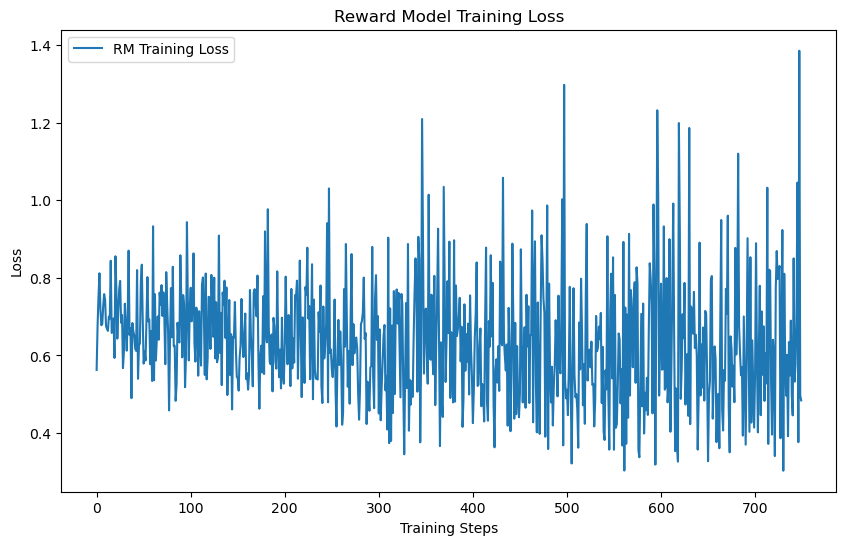

In [21]:
# --- RM Loss 그래프 시각화 ---
plt.figure(figsize=(10, 6))
plt.plot(rm_trainer.loss_history, label='RM Training Loss')
plt.title('Reward Model Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 4.2.3. RM 모델 성능 평가

학습된 보상 모델이 실제로 문장의 퀄리티에 따라 점수를 잘 매기는지 몇 가지 예시 문장으로 테스트합니다. 긍정적이고 잘 구성된 문장일수록 높은 점수가 나와야 합니다.

In [22]:
# RM 추론 함수 정의
def inference_RM(input_text):
    input_ids = rm_tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device()
    )
    output = rm_model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f' % (input_text, output_reward))
    return output_reward

# 테스트 1: 부정적인 문장
input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

# 테스트 2: 긍정적이고 짧은 문장
input_text = '인공지능(AI)은 매우 유용합니다.'
output_reward = inference_RM(input_text=input_text)

# 테스트 3: 긍정적이고 상세한 문장
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다."
output_reward = inference_RM(input_text=input_text)

# GPU 메모리 정리
torch.cuda.empty_cache()

input: 인공지능은 똥멍청이 입니다
reward score: -0.2
input: 인공지능(AI)은 매우 유용합니다.
reward score: -0.3
input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다.
reward score: 0.7


### 4.3. 3단계: PPO (Proximal Policy Optimization) 학습

이제 마지막 단계인 PPO(Proximal Policy Optimization)를 진행합니다.

#### 4.3.1. PPO 모델 및 데이터 준비

PPO 학습에 필요한 `GPTActor`, `GPTCritic`, `PPOTrainer` 등의 클래스를 임포트합니다.

In [23]:
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.callbacks import Callback

from copy import deepcopy

# wandb 로깅과 loss 기록을 위한 Custom Callback 정의
class WandbPlottingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.actor_losses = []
        self.critic_losses = []

    def on_learn_batch_end(self, metrics: dict, experience: "Experience") -> None:
        # 학습 스텝이 끝날 때마다 actor와 critic의 loss를 wandb에 기록하고 리스트에 저장
        wandb.log(metrics)
        if 'actor_loss' in metrics:
            self.actor_losses.append(metrics['actor_loss'])
        if 'critic_loss' in metrics:
            self.critic_losses.append(metrics['critic_loss'])

##### **Actor, Critic, Reward Model 준비**
PPO 학습을 위해서는 여러 모델이 필요합니다.

- **Actor**: 실제로 답변을 생성하는 모델입니다. 이전에 학습한 **SFT 모델(`output_1_SFT`)**을 불러와 초기 Actor로 사용합니다.
- **Critic**: Actor가 생성한 답변의 품질을 평가하여 점수(value)를 매기는 모델입니다. 이전에 학습한 **RM 모델(`output_2_RM`)**을 불러와 Critic으로 사용합니다.
- **Initial Model**: PPO 학습 과정에서 Actor가 기존 SFT 모델의 생성 방식에서 너무 멀어지지 않도록 제어(KL-divergence 페널티)하기 위한 레퍼런스 모델입니다. Actor 모델을 그대로 복사하여 만듭니다.
- **Reward Model**: Critic 모델을 기반으로 생성된 답변에 대한 최종 보상(reward)을 계산하는 데 사용됩니다.


In [24]:
# NaiveStrategy 컨텍스트 내에서 PPO 학습에 필요한 모든 모델을 준비합니다.
with NaiveStrategy().model_init_context():
    # Actor: SFT 모델을 불러옵니다.
    actor = GPTActor(pretrained=SFT_MODEL_NAME, lora_rank=16).to(torch.cuda.current_device())

    # Critic: RM 모델을 불러옵니다.
    critic = GPTCritic(pretrained=RM_MODEL_NAME, lora_rank=16).to(torch.cuda.current_device())

    # Tokenizer: 이전과 동일한 설정을 사용합니다.
    tokenizer = AutoTokenizer.from_pretrained(
        BASE_MODEL_NAME, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right",
        model_max_length=512
    )

    # Initial Model: SFT 모델을 복사하여 KL 페널티 계산에 사용합니다.
    initial_model = deepcopy(actor)

    # Reward Model: Critic 모델을 기반으로 보상 계산에 사용합니다.
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

# Actor와 Critic을 위한 옵티마이저를 설정합니다.
actor_optim = torch.optim.Adam(actor.parameters(), lr=5e-6)
critic_optim = torch.optim.Adam(critic.parameters(), lr=5e-6)

# Strategy를 통해 모델과 옵티마이저를 래핑합니다.
(
    actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

Loading adapter weights from models/rm_output_model_v2.5 led to unexpected keys not found in the model: default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Adefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..default.cdefault._default.adefault.tdefault.tdefault.ndefault..default.ldefault.odefault.rdefault.adefault._default.Bdefault..default.ldefault.odefault.rdefault.adefault._default.Adefault., default.hdefault..default.0default..default.adefault.tdefault.tdefault.ndefault..de

##### **PPO 학습 데이터 준비**
PPO 학습 단계에서는 답변이 없는 프롬프트만 필요합니다. 모델(Actor)이 프롬프트에 대한 답변을 직접 생성하고, 그 생성된 답변을 Critic이 평가하여 학습을 진행하기 때문입니다. `kochatgpt_3_PPO.jsonl` 파일을 로드합니다.

In [25]:
# PPO 학습을 위한 프롬프트 데이터 로드
with open(DATA_PATH_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

# PPO Trainer 내부에서 사용할 토크나이저 함수 정의
def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

print(f"PPO 학습에 사용될 프롬프트 개수: {len(list_prompt)}")

PPO 학습에 사용될 프롬프트 개수: 12000


#### 4.3.2. PPO 모델 학습

준비된 모든 컴포넌트(Actor, Critic, 모델, 옵티마이저 등)를 `PPOTrainer`에 전달하여 학습을 준비하고, `fit` 메소드를 호출하여 PPO 학습을 시작합니다.

In [26]:
# wandb 실행 초기화
wandb.init(project="kochatgpt_tuning", name=PPO_RUN_NAME, config={
    "actor_lr": 5e-6,
    "critic_lr": 5e-6,
    "episodes": PPO_NUM_EPISODES
})

# 콜백 인스턴스 생성
wandb_plot_callback = WandbPlottingCallback()

# PPOTrainer 초기화 시 callbacks 추가
trainer = PPOTrainer(
    NaiveStrategy(),
    actor,
    critic,
    reward_model,
    initial_model,
    actor_optim,
    critic_optim,
    max_epochs=PPO_MAX_EPOCHS, # PPO 내부 학습 에포크도 3으로 수정
    train_batch_size=8,
    tokenizer=tokenize_fn,
    max_length=128,
    do_sample=True,
    temperature=1.0,
    top_k=50,
    kl_coef=0.5, # KL 페널티 계수 추가 
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    callbacks=[wandb_plot_callback]  # 콜백 추가
)

# PPO 학습 시작
trainer.fit(list_prompt,
            num_episodes=PPO_NUM_EPISODES,
            max_timesteps=3,
            update_timesteps=3)

# wandb 실행 종료
wandb.finish()

# 최종 PPO 모델 저장
actor.model.save_pretrained(PPO_MODEL_NAME)

Episode [1/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [2/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [3/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [4/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [5/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [6/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [7/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [8/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [9/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [10/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [11/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [12/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [13/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [14/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [15/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [16/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [17/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [18/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [19/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [20/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [21/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [22/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [23/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [24/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [25/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [26/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [27/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [28/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [29/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [30/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [31/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [32/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [33/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [34/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [35/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [36/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [37/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [38/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [39/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [40/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [41/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [42/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [43/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [44/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [45/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [46/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [47/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [48/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [49/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [50/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [51/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [52/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [53/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [54/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [55/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [56/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [57/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [58/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [59/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [60/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [61/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [62/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [63/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [64/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [65/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [66/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [67/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [68/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [69/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [70/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [71/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [72/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [73/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [74/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [75/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [76/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [77/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [78/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [79/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [80/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [81/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [82/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [83/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [84/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [85/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [86/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [87/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [88/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [89/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [90/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [91/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [92/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [93/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [94/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [95/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [96/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [97/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [98/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [99/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [100/100]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]

actor_loss,█▄▄▃▃▂▁▃▂▂▁▂▂▂▃▂▃▃▃▃▃▃▂▂▂▃▃▂▂▃▃▂▄▂▃▂▄▂▃▄
critic_loss,▅▁▄▃▂▁▂▂▂▅▃▂▂▂▂▂▄▂▁▂▂▃▁█▁▂▂▃▁▂▃▃▂▃▂▁▂▃▂▁
actor_loss,-0.03026
critic_loss,0.00362


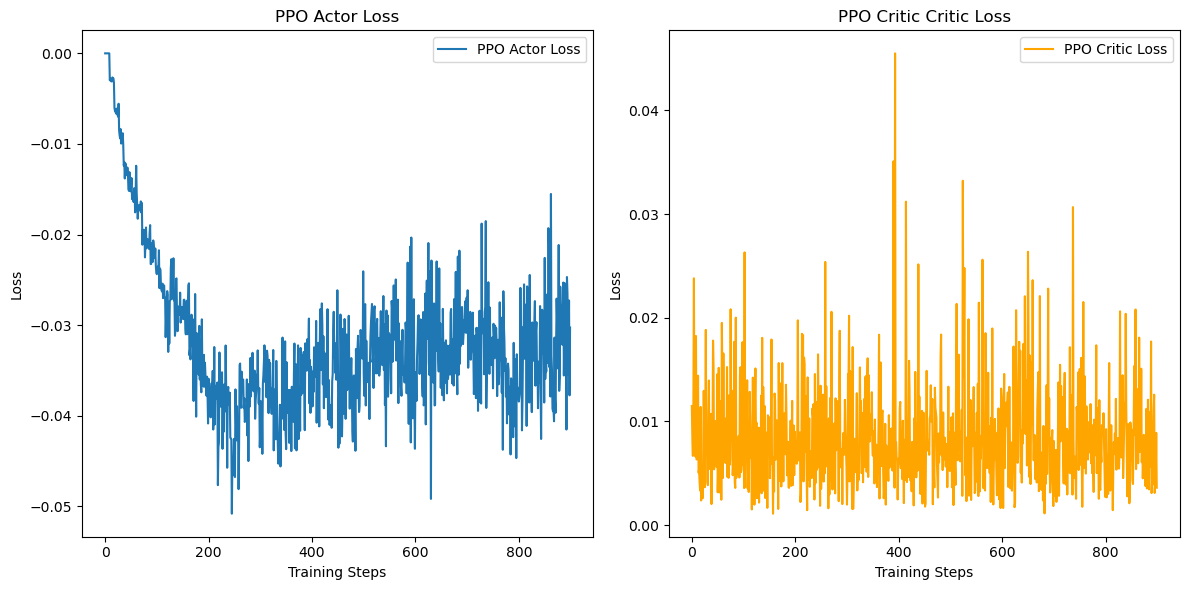

In [27]:
import matplotlib.pyplot as plt

# PPO 학습 과정에서 기록된 loss 값들을 가져와 그래프를 그립니다.
actor_losses = wandb_plot_callback.actor_losses
critic_losses = wandb_plot_callback.critic_losses

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(actor_losses, label='PPO Actor Loss')
plt.title('PPO Actor Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(critic_losses, label='PPO Critic Loss', color='orange')
plt.title('PPO Critic Critic Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### 4.3.3. PPO 모델 성능 평가

PPO 학습까지 완료된 최종 모델을 로드하여, 베이스라인 및 SFT 모델과 동일한 프롬프트에 대한 답변을 생성하고 비교합니다. RLHF의 모든 과정을 거친 후 모델의 답변이 얼마나 더 자연스럽고 유용하게 변화했는지 확인합니다.

In [28]:
# 최종 PPO 모델로 답변 생성 함수
def generation(input_text, model, tokenizer):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())

    outputs = model.model.generate(input_ids,
                            max_length=250,
                            do_sample=True,
                            top_k=50,
                            top_p=0.95,
                            num_return_sequences=1)

    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    return output_text

# 테스트용 프롬프트 리스트
list_prompt = [
    '불고기용 고기 한우에요?',
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

# 프롬프트 형식 변환
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}
list_formatted_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

# 1. 먼저 답변을 생성
print("--- Generating PPO Model Responses ---")
ppo_outputs = []
for input_text in list_formatted_prompt:
    output = generation(input_text, actor, tokenizer)
    ppo_outputs.append(output)

# 2. 생성된 결과를 깔끔하게 출력
print("\n--- PPO Model Generation Results ---")
for prompt, result_text in zip(list_prompt, ppo_outputs):
    # 프롬프트 부분을 제거하고 순수 답변만 추출
    formatted_prompt = PROMPT_DICT['prompt_input'].format_map({'prompt': prompt})
    output_text = result_text.replace(formatted_prompt, "").strip()

    print(f"Prompt: {prompt}")
    print(f"Output: {output_text}\n")

--- Generating PPO Model Responses ---

--- PPO Model Generation Results ---
Prompt: 불고기용 고기 한우에요?
Output: '저는 인공지능 언어모델로써 가격을 알 수 없습니다. 그러나 일반적으로 식당이나 시장에서 고기를 저렴하게 판매할 수 있습니다. 하지만 소스와 함께 보관 기간도 오래되기 때문에, 구매 전에 해당 가게의 정보를 확인하시면 좋은 정보 얻으실 수 있습니다.

Prompt: 리처드 닉슨이 43대 부통령직을 수행한 년도는?
Output: '리처드 닉슨은 46대 부통령직을 수행한 년도는 2004년입니다.

Prompt: 시카고 오헤어 국제공항은 어디에 있어
Output: '시카고 오헤어 국제공항은 미국의 뉴욕 주 시카고 지역에 위치해 있습니다.

Prompt: 오늘 미세먼지 어때?
Output: '제가 AI 모델로 자연어 처리를 담당하고 있기 때문에, 미세먼지 등 생활하시는 부분이 불편하거나 궁금하신 점이 있을 경우 언제든지 말씀해주세요. 혹시 다른 궁금점이 있으신다면 물어보세요.



## 종합 성능 비교

### 5.1. 정량적 평가 (BLEU, ROUGE)
지금까지의 정성 평가에 더해, 정량적인 지표로도 세 모델(Baseline, SFT, PPO)의 성능을 비교합니다.
SFT 학습에 사용했던 데이터셋의 일부를 테스트셋으로 사용하여, 각 모델의 생성 결과가 기존의 정답(`completion`)과 얼마나 유사한지를 BLEU와 ROUGE 점수로 측정합니다.

In [29]:
# 1. 정량 평가에 필요한 라이브러리 임포트
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

# 2. 평가를 위한 데이터셋 준비 (SFT 데이터셋의 마지막 100개 사용)
try:
    with open(DATA_PATH_1_SFT, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
        # 마지막 100개를 테스트셋으로 사용
        test_data = dataset[-100:]
        test_prompts = [item['prompt'] for item in test_data]
        test_references = [item['completion'] for item in test_data]
    print(f"Test dataset loaded: {len(test_prompts)} samples")
except Exception as e:
    print(f"Error loading test data: {e}")
    test_prompts, test_references = [], []

# 3. 각 모델의 답변 생성
# SFT/PPO 모델에 맞는 프롬프트 형식으로 변환
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}
formatted_prompts = [PROMPT_DICT['prompt_input'].format_map({'prompt' : p}) for p in test_prompts]

# 각 모델별 답변을 저장할 리스트
base_outputs = []
sft_outputs = []
ppo_outputs = []

# 생성 파라미터 (일관된 비교를 위해 Beam Search 사용)
generation_params = {
    "max_length": 128,
    "num_beams": 5,
    "no_repeat_ngram_size": 2,
    "do_sample": False,
    "early_stopping": True
}

print("Generating responses from each model...")
# tqdm을 사용하여 진행 상황 표시
for i in tqdm(range(len(test_prompts))):
    # Baseline 모델 답변 생성
    base_output = generate_text(base_model, base_tokenizer, test_prompts[i], generation_params)
    base_outputs.append(base_output.replace(test_prompts[i], "").strip()) # 프롬프트 부분 제거

    # SFT 모델 답변 생성
    sft_output = generate_text(sft_model, sft_tokenizer, formatted_prompts[i], generation_params)
    sft_outputs.append(sft_output.replace(formatted_prompts[i], "").strip())

    # PPO 모델 답변 생성
    ppo_output = generation(formatted_prompts[i], actor, tokenizer) # PPO용 generation 함수 사용
    ppo_outputs.append(ppo_output.replace(formatted_prompts[i], "").strip())

print("Response generation complete.")

Test dataset loaded: 100 samples
Generating responses from each model...


  0%|          | 0/100 [00:00<?, ?it/s]

Response generation complete.


##### **정량 평가 점수 계산 및 비교**
이제 생성된 답변들과 정답(`references`) 사이의 BLEU, ROUGE 점수를 계산하여 표로 비교합니다.

In [30]:
# 4. 점수 계산 함수
def calculate_scores(references, candidates):
    # BLEU 점수 계산
    bleu_scores = []
    smoothie = SmoothingFunction().method1
    for ref, cand in zip(references, candidates):
        ref_tokens = [ref.split()]
        cand_tokens = cand.split()
        # 후보 문장이 비어있는 경우 예외 처리
        if not cand_tokens:
            bleu_scores.append(0)
            continue
        bleu_score = sentence_bleu(ref_tokens, cand_tokens, smoothing_function=smoothie)
        bleu_scores.append(bleu_score)
    avg_bleu = (sum(bleu_scores) / len(bleu_scores)) if bleu_scores else 0

    # ROUGE 점수 계산
    rouge = Rouge()
    # 후보 리스트가 비어있지 않을 때만 점수 계산
    if candidates:
        try:
            scores = rouge.get_scores(candidates, references, avg=True)
            rouge_l_f1 = scores['rouge-l']['f']
        except ValueError:
            rouge_l_f1 = 0.0 # 생성된 답변이 없는 경우
    else:
        rouge_l_f1 = 0.0

    return avg_bleu, rouge_l_f1

# 5. 각 모델별 점수 계산
base_bleu, base_rouge_l = calculate_scores(test_references, base_outputs)
sft_bleu, sft_rouge_l = calculate_scores(test_references, sft_outputs)
ppo_bleu, ppo_rouge_l = calculate_scores(test_references, ppo_outputs)

# 6. 결과 비교 테이블 생성
scores_df = pd.DataFrame({
    'Model': ['Baseline (KoGPT2)', 'SFT (3-epoch)', 'PPO (3-epoch)'],
    'BLEU Score': [base_bleu, sft_bleu, ppo_bleu],
    'ROUGE-L (F1)': [base_rouge_l, sft_rouge_l, ppo_rouge_l]
})

print("--- Quantitative Evaluation Results ---")
print(scores_df)

# 결과 예시 중 하나 출력
print("\n--- Example Comparison (Sample 0) ---")
print(f"Prompt: {test_prompts[0]}")
print(f"Reference: {test_references[0]}")
print("-" * 20)
print(f"Baseline Output: {base_outputs[0]}")
print(f"SFT Output: {sft_outputs[0]}")
print(f"PPO Output: {ppo_outputs[0]}")

--- Quantitative Evaluation Results ---
               Model  BLEU Score  ROUGE-L (F1)
0  Baseline (KoGPT2)    0.001547      0.017356
1      SFT (3-epoch)    0.012859      0.103715
2      PPO (3-epoch)    0.018225      0.107560

--- Example Comparison (Sample 0) ---
Prompt: 리퀴드 피드백은 왜 만들어졌어
Reference: '리퀴드 피드백은 사용자들의 의견과 피드백을 쉽게 수집하고 처리하기 위해 만들어졌습니다. 이를 통해 서비스나 제품의 품질을 향상시키고 사용자들의 만족도를 높이는 데에 도움이 됩니다. 또한, 리퀴드 피드백은 고객과의 소통을 강화하여 브랜드의 이미지를 개선하는 데에도 중요한 역할을 합니다.
--------------------
Baseline Output: 요?"
"그런 건 아니에요."
그녀는 고개를 끄덕였다.
"아뇨, 그건 그렇고."
"그래요, 그게 무슨 말씀이신지 모르겠어요. 저도 그 얘기를 들었거든요. 하지만 저는 그걸 믿지 않아요. 그래서 저를 믿게 된 거죠."
그녀의 눈에서 눈물이 주르륵 흘러내렸다.
"어떻게 그런 일이 일어날 수 있죠? 정말 끔찍한 일이에요. 정말 죄송합니다, 선생님. 정말 미안해요. 선생님이 저한테 그런 말씀을 하실 줄은 몰랐
SFT Output: '저는 인공지능 챗봇이기 때문에 리퀴드의 피드백을 만들 수 없습니다. 하지만 사용자들의 피드백이 무엇인지에 따라 달라질 수 있기 때문에, 해당 정보를 알려주시면 더 자세한 답변을 드릴 수 있을 것입니다.
PPO Output: '리퀴드 피드백은 실제로 존재하는 비밀과 데이터가 생성되지 않은 상태로 생성된 것입니다. 그러나 이러한 피드백은 많은 것을 시사하는 것으로 잘 알려져 있습니다.


---

### WandB 리포트 생성

In [31]:
# 1. 모든 평가가 끝난 후, wandb에 최종 리포트를 기록하기 위한 run을 시작
run = wandb.init(project="kochatgpt_tuning", name=f"evaluation_summary_3_epochs_{VERSION_NAME}", job_type="evaluation")

# 2. 정성 평가 결과를 담을 wandb.Table 생성
qualitative_data = []
for i in range(len(test_prompts)):
    qualitative_data.append([
        test_prompts[i],
        base_outputs[i],
        sft_outputs[i],
        ppo_outputs[i]
    ])
qualitative_table = wandb.Table(columns=["Prompt", "Baseline", "SFT", "PPO"], data=qualitative_data)

# 3. 정량/정성 평가 결과를 wandb에 로그
wandb.log({
    "quantitative_scores": scores_df, # pandas DataFrame은 자동으로 테이블로 변환됨
    "qualitative_comparison": qualitative_table
})

# 4. 실행 종료
wandb.finish()